In [15]:
!pip install tweepy
!pip install textblob
import tweepy
from textblob import TextBlob
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
consumer_key = 'put yours'
consumer_secret = 'put yours'
access_token = 'put yours'
access_token_secret = 'put yours'

# Authenticate with Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Create API object
api = tweepy.API(auth)


auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)

api = tweepy.API(auth)


In [17]:
from requests.models import LocationParseError
#search_term = 'inecnigeria' #the Twitter account to search for
#search_term = 'blockchain AND (security OR hack OR vulnerability OR audit)' #the search strings or phrases
search_term = 'internet shutdowns'
#AND (blockchain scalability OR blockchain network congestion OR proof-of-work blockchain)'
since_date = '2023-04-01'
until_date = '2023-04-15'
location = '39.8283,-98.5795,2500km' # USA geocode
count = 1000


In [22]:
#df.head()

In [23]:
#https://github.com/zhengrui315/Twitter-Sentiment-Analysis/blob/master/twitter_emoji.ipynb

!pip install emoji
import emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import pandas as pd
import re
!pip install demoji
import demoji

# download demoji's emoji dictionary
demoji.download_codes()

# create empty list to store data
tweets_data = []

# loop through each tweet and extract relevant information
for tweet in tweepy.Cursor(api.search_tweets,
                           q=search_term,
                           #geocode=location,
                           lang='en',
                           #since_id=since_date,
                           count=count).items():
    tweet_text = tweet.text
    tweet_user = tweet.user.screen_name
    tweet_date = tweet.created_at
    #tweet_location = tweet.user.location

    # remove web links
    tweet_text = re.sub(r'http\S+', '', tweet_text)

    # remove usernames and mentions
    tweet_text = re.sub(r'@[^\s]+', '', tweet_text)

    # remove emojis
    emoji_less_text = demoji.replace(tweet_text, "")

    # remove extra white spaces
    tweet_text = re.sub(r'\s+', ' ', emoji_less_text)

    # remove any remaining non-alphanumeric characters and convert to lowercase
    tweet_text = re.sub(r'[^a-zA-Z0-9\s]', '', tweet_text)
    tweet_text = tweet_text.lower()

    # remove non-alphanumeric characters
    alphanumeric_text = re.sub(r'[^a-zA-Z0-9\s]', '', emoji_less_text)

    # append cleaned tweet data to tweets_data list
    tweet_data = [tweet_text, tweet_user, tweet_date] #,tweet_location]
    tweets_data.append(tweet_data)

# create DataFrame from tweets data
df = pd.DataFrame(data=tweets_data, columns=['text', 'user', 'date']) #, 'location'])


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-24-69b2ae2d0a63>:7: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [25]:
df.head()

,text,user,date
0,rt elections in tanzania continue to be a trig...,Ramdankg123,2023-04-24 06:50:59+00:00
1,rt elections in tanzania continue to be a trig...,TheIcontz,2023-04-24 06:48:35+00:00
2,rt elections in tanzania continue to be a trig...,TheIcontz,2023-04-24 06:48:17+00:00
3,rt chad government declared that its interrupt...,MjahidOsama,2023-04-24 06:46:29+00:00
4,rt internet shutdowns in tanzania continued to...,MjahidOsama,2023-04-24 06:46:00+00:00


In [26]:
from textblob import TextBlob

# add sentiment polarity and subjectivity columns to the dataframe
df['polarity'] = df['text'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda tweet: TextBlob(tweet).sentiment.subjectivity)

# classify tweets as positive, negative, or neutral based on polarity scores
df['sentiment'] = df['polarity'].apply(lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral'))


In [27]:
df.head()

,text,user,date,polarity,subjectivity,sentiment
0,rt elections in tanzania continue to be a trig...,Ramdankg123,2023-04-24 06:50:59+00:00,-0.155556,0.288889,negative
1,rt elections in tanzania continue to be a trig...,TheIcontz,2023-04-24 06:48:35+00:00,-0.155556,0.288889,negative
2,rt elections in tanzania continue to be a trig...,TheIcontz,2023-04-24 06:48:17+00:00,-0.155556,0.288889,negative
3,rt chad government declared that its interrupt...,MjahidOsama,2023-04-24 06:46:29+00:00,0.016667,0.083333,positive
4,rt internet shutdowns in tanzania continued to...,MjahidOsama,2023-04-24 06:46:00+00:00,0.000000,0.100000,neutral


Positive tweets percentage: 48.67776689520078
Negative tweets percentage: 3.819784524975514
Neutral tweets percentage: 47.5024485798237


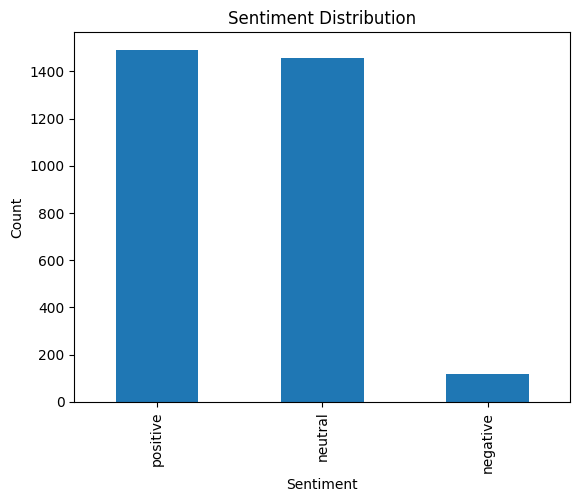

In [28]:
# count the number of tweets for each sentiment
sentiment_counts = df['sentiment'].value_counts()

# calculate the percentage of tweets for each sentiment
positive_percentage = sentiment_counts['positive'] / len(df) * 100
negative_percentage = sentiment_counts['negative'] / len(df) * 100
neutral_percentage = sentiment_counts['neutral'] / len(df) * 100

print("Positive tweets percentage:", positive_percentage)
print("Negative tweets percentage:", negative_percentage)
print("Neutral tweets percentage:", neutral_percentage)


import matplotlib.pyplot as plt

# plot the sentiment distribution
sentiment_counts.plot.bar()

# add titles and labels to the plot
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# show the plot
plt.show()


In [29]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# define X (features) and y (target) variables
X = df['text']
y = df['sentiment']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# vectorize the text data using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# define the LGB classifier model
lgb_clf = lgb.LGBMClassifier()

# train the model on the training data
lgb_clf.fit(X_train_vec, y_train)

# make predictions on the testing data
y_pred = lgb_clf.predict(X_test_vec)

# calculate accuracy score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")


Accuracy: 0.9815016322089227


**remember to try model distillation**

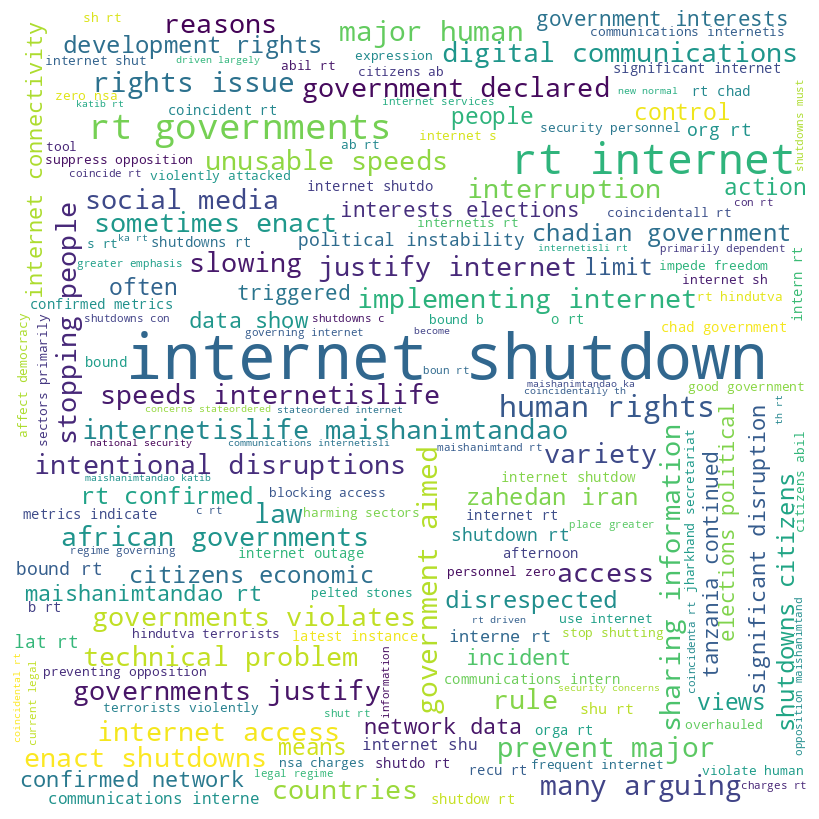

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# create a string containing all the tweets
all_tweets = ' '.join(df['text'].tolist())

# generate a wordcloud plot
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(all_tweets)

# plot the wordcloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3063 entries, 0 to 3062
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   text          3063 non-null   object             
 1   user          3063 non-null   object             
 2   date          3063 non-null   datetime64[ns, UTC]
 3   polarity      3063 non-null   float64            
 4   subjectivity  3063 non-null   float64            
 5   sentiment     3063 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(2), object(3)
memory usage: 143.7+ KB


In [32]:
print(len(df))


3063


In [34]:
df.to_csv('internetshutdowntweets.csv', index=False)
